# Sentiment Analysis of Product Reviews leveraging LSTM Network

`Sentiment Analysis` is determining whether a written piece of text has a `positive`, `neutral`, or `negative` connotation. These written pieces of text are usually the reviews that are left by customers once they use products, brands, services, and so forth. These reviews give an insight into how appealing or off-putting a particular product, brand, or service was to the customer. These `insights` are extremely useful because they are not only an indicator of `customer satisfaction` but also companies can use them to `drive business decisions`.

`Consumer Reviews of Amazon Products` is the dataset that will be used. It has a reasonable dimension i.e. it has over 34,000 consumer reviews for Amazon products like the Kindle, Fire TV Stick, and so forth. The dataset includes basic product information such as name, review title, review text, review rating, and more for each product. The dataset is publicly available on [Kaggle](https://www.kaggle.com/datasets/datafiniti/consumer-reviews-of-amazon-products). In this dataset, the column `reviews.rating` has values ranging from 1 to 5. These values will be updated so that each of them corresponds to a sentiment. Values 1 and 2 will be treated as a negative sentiment (0), value 3 will be treated as a neutral sentiment (1), and values 4 and 5 will be treated as a positive sentiment (2). Additionally, the column `reviews.text` holds the reviews.

## **Table of Contents**

1. [Mounting the Drive](#Mounting-the-Drive)
2. [Importing the Required Libraries](#Importing-the-Required-Libraries)
2. [Common Utility Functions](#Common-Utility-Functions)
3. [Reading Data](#Reading-Data)
4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
5. [Data Cleaning](#Data-Cleaning)
6. [Top Words](#Top-Words)
7. [Data Splitting](#Data-Splitting)
8. [Tokenization](#Tokenization)
9. [Padding](#Padding)
10. [Embedding](#Embedding)
11. [Evaluation Metric](#Evaluation-Metric)
  - [Accuracy](#Accuracy)
  - [Better Metric](#Better-Metric)
12. [Sentiment Model](#Sentiment-Model)
  - [Whole Test Set](#Whole-Test-Set)
  - [Model Definition](#Model-Definition)
  - [Different Sentiment Models](#Different-Sentiment-Models)
  - [A Few Results](#A-Few-Results)
13. [2 LSTM Layers with 64 Units](#2-LSTM-Layers-with-64-Units)
  - [Initial Model](#Initial-Model)
  - [Model with Class Weights](#Model-with-Class-Weights)
  - [Model with Synthetic Oversampled Data](#Model-with-Synthetic-Oversampled-Data)
14. [Takeaways](#Takeaways)

## Mounting the Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing the Required Libraries

In [ ]:
# importing tabular data and matrices handlers
import pandas as pd
import numpy as np

# importing string operations
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

# keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

# oversampling
from imblearn.over_sampling import SMOTE

# word embeddings
!wget --no-check-certificate \
     http://nlp.stanford.edu/data/glove.6B.zip \
     -O /tmp/glove.6B.zip

# importing visualization packages
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

# configuring visualizations
%matplotlib inline
mpl.style.use( 'ggplot' )
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)
params = { 
    'axes.labelsize': "small",
    'xtick.labelsize': 'small',
    'legend.fontsize': 20,
    'figure.dpi': 100,
    'figure.figsize': [15, 7]
}
plt.rcParams.update(params)

# utilities
import os
import zipfile
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


--2022-11-30 18:24:53--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-11-30 18:24:54--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-11-30 18:24:54--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/tmp/glove.6B.zip’


## Common Utility Functions

A few utility functions that are used multiple times throughout the code.

In [ ]:
# given the path, reading the dataset
def get_dataframe(csv_path):
  df_new = pd.read_csv(csv_path,low_memory=False)
  return df_new

In [ ]:
# updating the column names
def update_column_names(df_existing):
  df_existing.rename(columns={'reviews.rating': 'rating', 'reviews.text': 'text'}, inplace=True)
  return df_existing

In [ ]:
# dropping all columns apart from the ones of interest
def drop_unnecessary_columns(df_exisiting):
  df_exisiting.drop(df_exisiting.columns.difference(['rating','text']), axis=1, inplace=True)
  return df_exisiting

In [ ]:
# mapping the rating (1,2,3,4,5) to a sentiment class (negative, neutral, positive) in the existing dataframe
# rating 1 and 2 to negative (0)
# rating 3 to neutral (1)
# rating 4 and 5 to positve (2)

# creating new columns named 'sentiment_score' and 'sentiment' that will hold the values post mapping
def get_mapped_dataframe(df_existing):
  rating_to_sentiment = {
      1 : 0,
      2 : 0,
      3 : 1,
      4 : 2,
      5 : 2
  }

  score_to_sentiment = {
      0 : 'Negative',
      1 : 'Neutral',
      2 : 'Positive'
  }

  df_existing['sentiment_score'] = df_existing['rating'].map(rating_to_sentiment)
  df_existing['sentiment'] = df_existing['sentiment_score'].map(score_to_sentiment)

  return df_existing

In [ ]:
# viewing class balance by getting count per sentiment
def get_count_per_sentiment(df_existing):
  count_per_sentiment = df_existing.groupby('sentiment_score').count()['sentiment'].reset_index().sort_values(by='sentiment',ascending=False)
  return count_per_sentiment.style.background_gradient(cmap='Blues').hide_index()

In [ ]:
# viewing the plot of top words per sentiment
def get_top_words_per_sentiment(df_existing):
  top = Counter([item for sublist in df_existing['words'] for item in sublist])
  top_words = pd.DataFrame(top.most_common(15))
  top_words.columns = ['top_words','count']
  return sns.barplot(x="count", y="top_words", data=top_words)

## Reading Data

In [ ]:
# reading dataset in a dataframe
csv_path = '/content/drive/MyDrive/1429_1.csv.csv'
df_reviews = get_dataframe(csv_path)

## Exploratory Data Analysis

Analyzing the dataset.

In [ ]:
# viewing the shape of the dataframe
df_reviews.shape

(34660, 21)

There are `34660 product reviews` and the details for each are spread across 21 columns.

In [ ]:
# viewing the high level information of the dataframe
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    34660 non-null  object 
 1   name                  27900 non-null  object 
 2   asins                 34658 non-null  object 
 3   brand                 34660 non-null  object 
 4   categories            34660 non-null  object 
 5   keys                  34660 non-null  object 
 6   manufacturer          34660 non-null  object 
 7   reviews.date          34621 non-null  object 
 8   reviews.dateAdded     24039 non-null  object 
 9   reviews.dateSeen      34660 non-null  object 
 10  reviews.didPurchase   1 non-null      object 
 11  reviews.doRecommend   34066 non-null  object 
 12  reviews.id            1 non-null      float64
 13  reviews.numHelpful    34131 non-null  float64
 14  reviews.rating        34627 non-null  float64
 15  reviews.sourceURLs 

There are null values in a few columns. However, the column of interest here are reviews.rating and reviews.text.

In [ ]:
# updating the column names
df_reviews = update_column_names(df_reviews)

In [ ]:
# dropping all columns apart from the ones of interest
df_reviews = drop_unnecessary_columns(df_reviews)

In [ ]:
# viewing the high level information of the dataset after dropping columns
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rating  34627 non-null  float64
 1   text    34659 non-null  object 
dtypes: float64(1), object(1)
memory usage: 541.7+ KB


There are 33 rows for which the rating is missing and 1 row for which the text is missing. Hence, dropping those 34 rows.

In [ ]:
# dropping rows that have null values
df_reviews.dropna(inplace=True)

In [ ]:
# viewing the high level information of the dataset after dropping rows
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34626 entries, 0 to 34659
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rating  34626 non-null  float64
 1   text    34626 non-null  object 
dtypes: float64(1), object(1)
memory usage: 811.5+ KB


There are no more null values in the rating and text column.

In [ ]:
# viewing first five rows of the dataset
df_reviews.head().style.hide_index()

rating,text
5.000000,This product so far has not disappointed. My children love to use it and I like the ability to monitor control what content they see with ease.
5.000000,great for beginner or experienced person. Bought as a gift and she loves it
5.000000,"Inexpensive tablet for him to use and learn on, step up from the NABI. He was thrilled with it, learn how to Skype on it already..."
4.000000,I've had my Fire HD 8 two weeks now and I love it. This tablet is a great value.We are Prime Members and that is where this tablet SHINES. I love being able to easily access all of the Prime content as well as movies you can download and watch laterThis has a 1280/800 screen which has some really nice look to it its nice and crisp and very bright infact it is brighter then the ipad pro costing $900 base model. The build on this fire is INSANELY AWESOME running at only 7.7mm thick and the smooth glossy feel on the back it is really amazing to hold its like the futuristic tab in ur hands.
5.000000,"I bought this for my grand daughter when she comes over to visit. I set it up with her as the user, entered her age and name and now Amazon makes sure that she only accesses sites and content that are appropriate to her age. Simple to do and she loves the capabilities. I also bought and installed a 64gig SD card which gives this little tablet plenty of storage. For the price I think this tablet is best one out there. You can spend hundreds of dollars more for additional speed and capacity but when it comes to the basics this tablets does everything that most people will ever need at a fraction of the cost."


In [ ]:
# creating new columns named 'sentiment_score' and 'sentiment' that will hold the values post mapping
df_reviews = get_mapped_dataframe(df_reviews)

In [ ]:
# viewing first five rows of the dataset after mapping
df_reviews.head().style.hide_index()

rating,text,sentiment_score,sentiment
5.000000,This product so far has not disappointed. My children love to use it and I like the ability to monitor control what content they see with ease.,2,Positive
5.000000,great for beginner or experienced person. Bought as a gift and she loves it,2,Positive
5.000000,"Inexpensive tablet for him to use and learn on, step up from the NABI. He was thrilled with it, learn how to Skype on it already...",2,Positive
4.000000,I've had my Fire HD 8 two weeks now and I love it. This tablet is a great value.We are Prime Members and that is where this tablet SHINES. I love being able to easily access all of the Prime content as well as movies you can download and watch laterThis has a 1280/800 screen which has some really nice look to it its nice and crisp and very bright infact it is brighter then the ipad pro costing $900 base model. The build on this fire is INSANELY AWESOME running at only 7.7mm thick and the smooth glossy feel on the back it is really amazing to hold its like the futuristic tab in ur hands.,2,Positive
5.000000,"I bought this for my grand daughter when she comes over to visit. I set it up with her as the user, entered her age and name and now Amazon makes sure that she only accesses sites and content that are appropriate to her age. Simple to do and she loves the capabilities. I also bought and installed a 64gig SD card which gives this little tablet plenty of storage. For the price I think this tablet is best one out there. You can spend hundreds of dollars more for additional speed and capacity but when it comes to the basics this tablets does everything that most people will ever need at a fraction of the cost.",2,Positive


In [ ]:
# viewing class balance by getting count per sentiment
get_count_per_sentiment(df_reviews)

sentiment_score,sentiment
2,32315
1,1499
0,812


More data will have to be added corresponding to the negative and neutral sentiment classes as there is a `huge imbalance` when compared with the positive sentiment class.

In [ ]:
# reading additional datasets in new dataframes
csv_path2 = '/content/drive/MyDrive/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv'
df_reviews2 = get_dataframe(csv_path2)

csv_path3 = '/content/drive/MyDrive/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv'
df_reviews3 = get_dataframe(csv_path3)

In [ ]:
# updating the column names of the new dataframe
df_reviews2 = update_column_names(df_reviews2)
df_reviews3 = update_column_names(df_reviews3)

In [ ]:
# dropping all columns apart from the ones of interest in new dataframes
df_reviews2 = drop_unnecessary_columns(df_reviews2)
df_reviews3 = drop_unnecessary_columns(df_reviews3)

In [ ]:
# selecting reviews that belong to either negative or neutral sentiment class while ignoring the positive sentiment class
df_reviews2 = df_reviews2[df_reviews2['rating']<=3]
df_reviews3 = df_reviews3[df_reviews3['rating']<=3]

In [ ]:
# creating new columns named 'sentiment_score' and 'sentiment' in new dataframes that will hold the values post mapping
df_reviews2 = get_mapped_dataframe(df_reviews2)
df_reviews3 = get_mapped_dataframe(df_reviews3)

In [ ]:
# concatenating data from all dataframes
df_reviews = pd.concat([df_reviews, df_reviews2, df_reviews3])

Dulicate instances (reviews and ratings) of the negative and neutral classes will have to be dropped as they may lead to model overfitting.

In [ ]:
# checking for duplicate rows
df_reviews[df_reviews.duplicated()]

,rating,text,sentiment_score,sentiment
0,3.0,I thought it would be as big as small paper bu...,1,Neutral
15,3.0,It does its job but I would buy one which the ...,1,Neutral
51,3.0,The kindle is good to download apps for books ...,1,Neutral
72,3.0,"For me, the Kindle Black was not a good fit fo...",1,Neutral
82,3.0,This is a pretty cool little device. Im able t...,1,Neutral
...,...,...,...,...
28265,1.0,"was cheap, can not run chrome stuff, returned ...",0,Negative
28268,2.0,Didn't have some of the features I was looking...,0,Negative
28269,2.0,My Hulu plays perfectly..great volume. Kindle ...,0,Negative
28285,1.0,Worked great but after awhile I wouldn't unloc...,0,Negative


There are `1501 rows` that are `duplicated` in the concatenated dataframe. All but one of each duplicated row will be dropped.

In [ ]:
# viewing a potential duplicate row
potential_duplicate_text = 'The kindle is good to download apps for books catch up with reading'
df_reviews[df_reviews['text']==potential_duplicate_text]

,rating,text,sentiment_score,sentiment
3584,3.0,The kindle is good to download apps for books ...,1,Neutral
51,3.0,The kindle is good to download apps for books ...,1,Neutral
1859,3.0,The kindle is good to download apps for books ...,1,Neutral
24662,3.0,The kindle is good to download apps for books ...,1,Neutral


In [ ]:
# dropping duplicate rows
df_reviews = df_reviews.drop_duplicates()

In [ ]:
# viewing class balance by getting count per sentiment
get_count_per_sentiment(df_reviews)

sentiment_score,sentiment
2,32315
1,2068
0,1843


There is a slight improvement in both the negative and neutral sentiment classes from before. However, the data is still unbalanced. An `intial model` will be built to see how it performs with the current situation and then later, techniques such as `assigning class weights` and `synthetic oversampling` will be used to `handle the imbalance`.

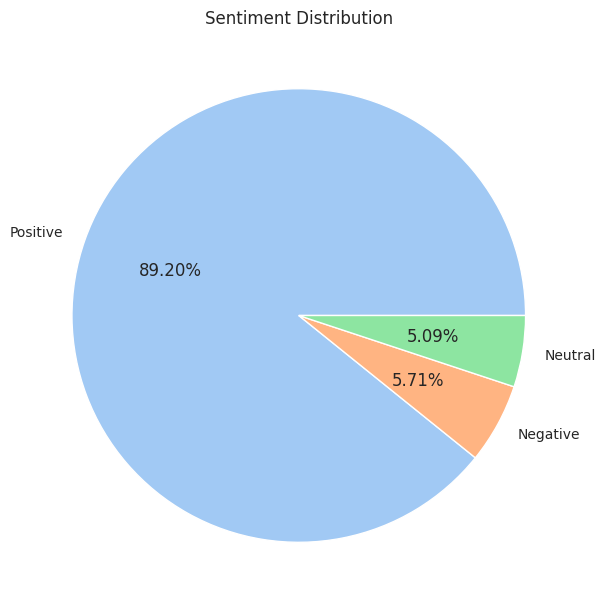

In [ ]:
# viewing sentiment distribution
data = df_reviews['sentiment_score'].value_counts()
labels = df_reviews['sentiment'].unique()
number_of_classes = len(labels)
colors = sns.color_palette('pastel')[0:number_of_classes]
plt.pie(data, labels = labels, colors = colors, autopct='%.2f%%')
plt.title('Sentiment Distribution')
plt.show()

In [ ]:
# saving the combined data
# df_reviews.to_csv("combined_reviews.csv")

In [ ]:
# viewing a few positive reviews
df_reviews[df_reviews['sentiment']=='Positive'].head().style.hide_index()

rating,text,sentiment_score,sentiment
5.000000,This product so far has not disappointed. My children love to use it and I like the ability to monitor control what content they see with ease.,2,Positive
5.000000,great for beginner or experienced person. Bought as a gift and she loves it,2,Positive
5.000000,"Inexpensive tablet for him to use and learn on, step up from the NABI. He was thrilled with it, learn how to Skype on it already...",2,Positive
4.000000,I've had my Fire HD 8 two weeks now and I love it. This tablet is a great value.We are Prime Members and that is where this tablet SHINES. I love being able to easily access all of the Prime content as well as movies you can download and watch laterThis has a 1280/800 screen which has some really nice look to it its nice and crisp and very bright infact it is brighter then the ipad pro costing $900 base model. The build on this fire is INSANELY AWESOME running at only 7.7mm thick and the smooth glossy feel on the back it is really amazing to hold its like the futuristic tab in ur hands.,2,Positive
5.000000,"I bought this for my grand daughter when she comes over to visit. I set it up with her as the user, entered her age and name and now Amazon makes sure that she only accesses sites and content that are appropriate to her age. Simple to do and she loves the capabilities. I also bought and installed a 64gig SD card which gives this little tablet plenty of storage. For the price I think this tablet is best one out there. You can spend hundreds of dollars more for additional speed and capacity but when it comes to the basics this tablets does everything that most people will ever need at a fraction of the cost.",2,Positive


In [ ]:
# viewing a few neutral reviews
df_reviews[df_reviews['sentiment']=='Neutral'].head().style.hide_index()

rating,text,sentiment_score,sentiment
3.000000,I was hoping to use Google launcher with this tablet but it is really locked down and you cannot change the launcher or the lock screen. Still cheap and fine for watching movies.,1,Neutral
3.000000,"The tablet works fine. It is responsive with good resolution. It is too tied to Amazon. It requires too many hoops to get apps such as Zinio to work. Until Amazon loosens its grip, I recommend only at a very good price.",1,Neutral
3.000000,"Fine for reading, ...haven't used it for anything else yet",1,Neutral
3.000000,"Though I have got it for cheap price during black friday, this Fire is not that great. Very bad camera and dim screen resolution. Pros:Install Google Play without any hassleVery good book reading option",1,Neutral
3.000000,"This is a good product for video, surfing and reading. However this version has dropped all android support as far as I can tell. I have a couple of apps that run on my old Fire just fine but are extremely problematic on this one. There is one app I use everyday but it doesn't work on this new Fire, so I have to keep the old one around. Kind of inconvenient. I would recommend seeing if your app is supported on this Fire before dropping the money.",1,Neutral


In [ ]:
# viewing a few negative reviews
df_reviews[df_reviews['sentiment']=='Negative'].head().style.hide_index()

rating,text,sentiment_score,sentiment
2.000000,Didn't have some of the features I was looking for. Returned it the next day. May be good for others,0,Negative
1.000000,"i Bought this around black friday for $60 hoping it would be awesome... it failed so hard i tried multiple different micro SD cards none of which were recognized and YES i formated them with every format i could think of ... Fat32, NTFS, Fat, Xfat... i even tried to have the tablet do it... didnt work... to make matters worse half the apps i wanted to use werent in the app store and i came to find out that it isnt linked to the normal google play store this tablet has its own app store which is missing many common apps... the main reason i bought this was to play clash of clans and i cant because it wasnt on the app store... i tried to also use aftermarket play stores to play COC but it didnt work... launched and played 1 time but didnt work or update after that... needless to say i returned it and bought a $250 samsung galaxy tab A 10.1 (2016 version) with S-pen and its WAYYYYY better... bottom line you get what you pay for... also hint the s-pen version has an extra 1 GB of ram over the non pen version... so you should get that if you can afford the extra $50...",0,Negative
1.000000,I bought this tablet for my 4 year old daughter. Too many advertisements. I would rather pay more and not have a single ad.,0,Negative
1.000000,Didn't want to go to the sites amazon wanted me to.,0,Negative
2.000000,Not a good product short battery life i can only use for 20 minutes,0,Negative


The text from all the sentiment classes seen above will have to be cleaned as they have numbers, ellipsis, english stop words, case difference, and so forth.

## Data Cleaning

The following is applied to each of the texts for all the sentiment classes:

- Conversion to string
- Conversion to lower case
- Removal of punctuations, URLs, @
- Removal of emoticons like ":)", ":-)", ":-]",":(", ":<", ":[", ":-("
- Removal of ellipsis
- Removal of HTML tags
- Removal of market tickers
- Removal of extra spaces and tabs
- Removal of digits
- Removal of words containinig numbers
- Removal of line breaks
- Removal of whitespaces
- Removal of stop words
- Lemmatizing

A part of this [link](https://www.kaggle.com/code/lystdo/lstm-with-word2vec-embeddings/script) was taken for the following function.

In [ ]:
wordnet_lemmatizer = WordNetLemmatizer()

# cleans a given text
def get_cleaned_text(text):

  text = str(text)

  text = text.translate(string.punctuation)
  text = text.strip()

  text = text.lower().split()

  stop_words = set(stopwords.words("english"))
  text = [word for word in text if not word in stop_words and len(word) >= 3]
  text = " ".join(text)

  text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
  text = re.sub(r"what's", "what is ", text)
  text = re.sub(r"\'s", " ", text)
  text = re.sub(r"\'ve", " have ", text)
  text = re.sub(r"n't", " not ", text)
  text = re.sub(r"i'm", "i am ", text)
  text = re.sub(r"\'re", " are ", text)
  text = re.sub(r"\'d", " would ", text)
  text = re.sub(r"\'ll", " will ", text)
  text = re.sub(r",", " ", text)
  text = re.sub(r"\.", " ", text)
  text = re.sub(r"!", " ! ", text)
  text = re.sub(r"\/", " ", text)
  text = re.sub(r"\^", " ^ ", text)
  text = re.sub(r"\+", " + ", text)
  text = re.sub(r"\-", " - ", text)
  text = re.sub(r"\=", " = ", text)
  text = re.sub(r"'", " ", text)
  text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
  text = re.sub(r":", " : ", text)
  text = re.sub(r" e g ", " eg ", text)
  text = re.sub(r" b g ", " bg ", text)
  text = re.sub(r" u s ", " american ", text)
  text = re.sub(r"\0s", "0", text)
  text = re.sub(r" 9 11 ", "911", text)
  text = re.sub(r"e - mail", "email", text)
  text = re.sub(r"j k", "jk", text)
  text = re.sub(r"\s{2,}", " ", text)
  text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
  text = re.sub("<.*?>+", "", text)
  text = re.sub("\$", "", text)
  text = re.sub("\s+", " ", text)
  text = re.sub(" \d+", " ", text)
  text = re.sub("\w*\d\w*", "", text)
  text = re.sub("\[.*?\]", "", text)
  text = re.sub("\n", "", text)

  text = text.split()
  lemmatized_words = [wordnet_lemmatizer.lemmatize(word) for word in text]
  text = " ".join(lemmatized_words)

  return text

In [ ]:
# storing cleaned review by updating the text column
df_reviews['text'] = df_reviews['text'].apply(lambda x:get_cleaned_text(x))

In [ ]:
# saving the cleaned data in a csv
# df_reviews.to_csv("cleaned_data.csv")

In [ ]:
# viewing first five rows of the cleaned reviews
df_reviews.head().style.hide_index()

rating,text,sentiment_score,sentiment
5.000000,product far disappointed child love use like ability monitor control content see ease,2,Positive
5.000000,great beginner experienced person bought gift love,2,Positive
5.000000,inexpensive tablet use learn on step nabi thrilled it learn skype already,2,Positive
4.000000,i have fire two week love it tablet great value we prime member tablet shine love able easily access prime content well movie download watch laterthis screen really nice look nice crisp bright infact brighter ipad pro costing base model build fire insanely awesome running mm thick smooth glossy feel back really amazing hold like futuristic tab hand,2,Positive
5.000000,bought grand daughter come visit set user entered age name amazon make sure access site content appropriate age simple love capability also bought installed gig card give little tablet plenty storage price think tablet best one there spend hundred dollar additional speed capacity come basic tablet everything people ever need fraction cost,2,Positive


## Top Words

Viewing top words from each class to see if the words really correspond to the sentiment class they show up in.

In [ ]:
# creating a new column that holds the list of words in the text
df_reviews['words'] = df_reviews['text'].apply(lambda x:str(x).split())

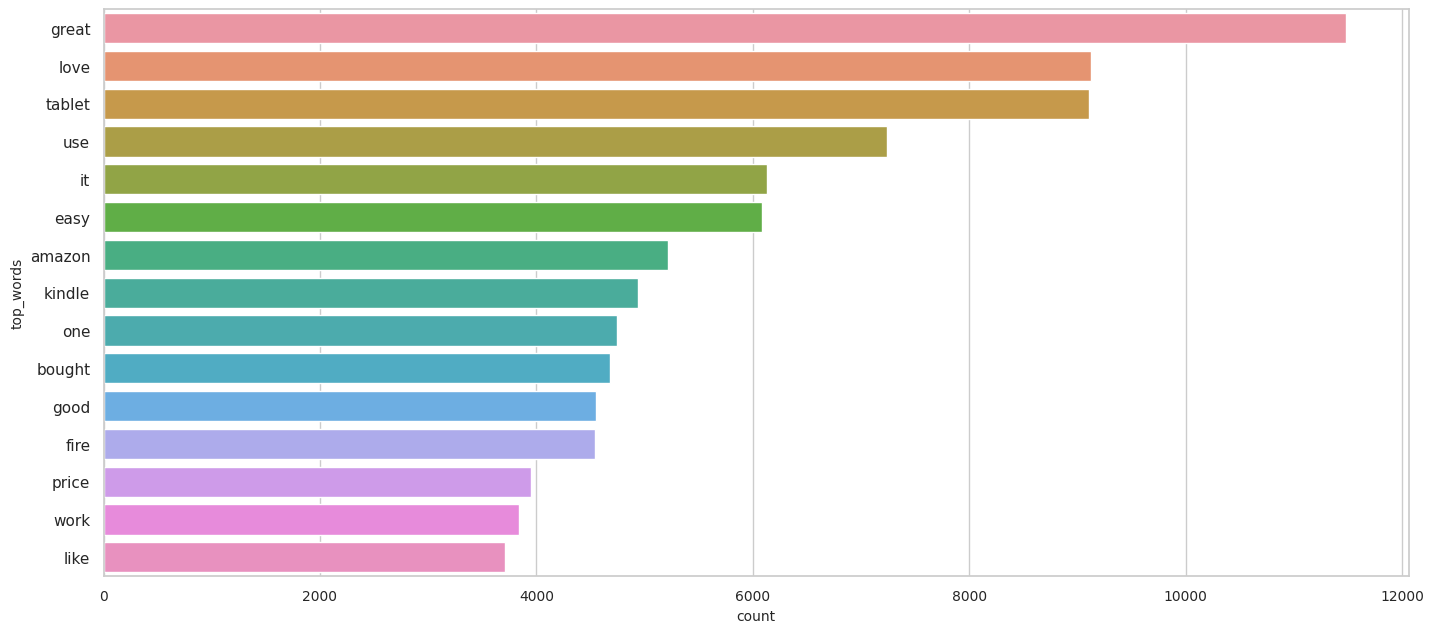

In [ ]:
# viewing the plot of top words of the positive sentiment class
df_positive_reviews = df_reviews[df_reviews['sentiment']=='Positive']
get_top_words_per_sentiment(df_positive_reviews)

Words such as great, good, like, love, and easy indeed correspond to the positive sentiment. There are a few generic words and words that are related to products such as tablet and kindle.

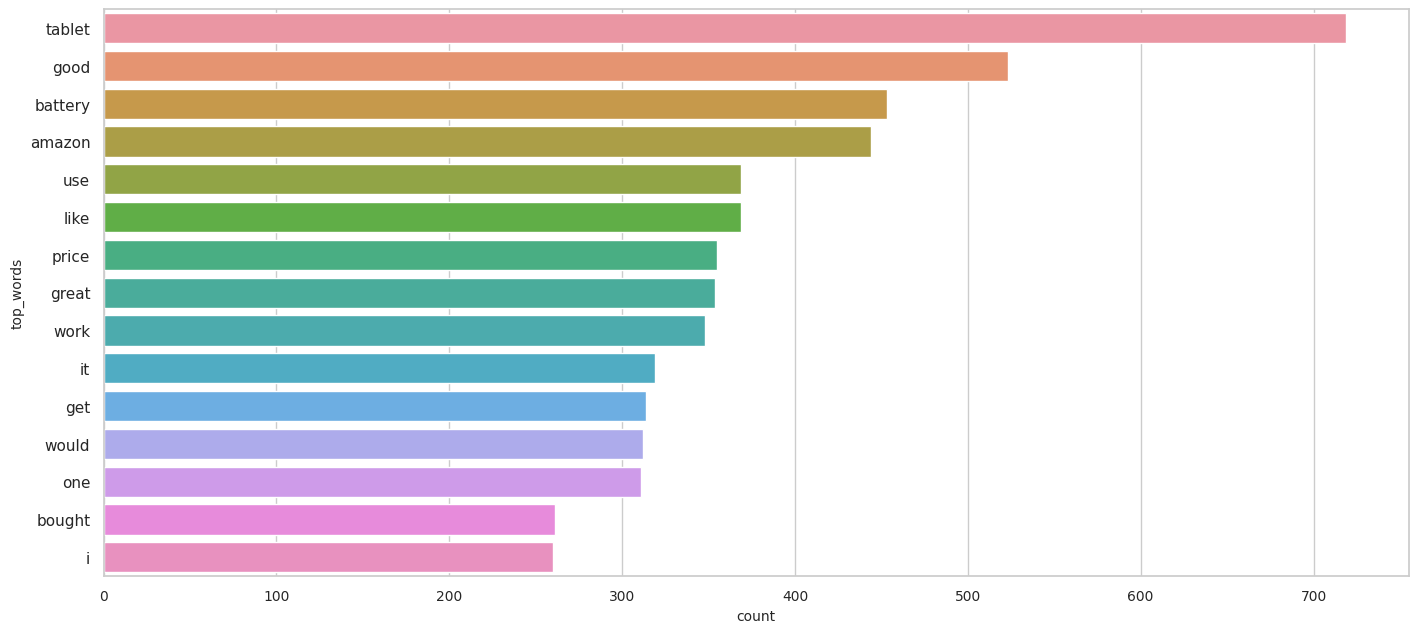

In [ ]:
# viewing the plot of top words of the neutral sentiment class
df_neutral_reviews = df_reviews[df_reviews['sentiment']=='Neutral']
get_top_words_per_sentiment(df_neutral_reviews)

There are a lot of words that are common between the top words of neutral class and the top words of the positive class. Some of such words are great, good, and like. Even the word tablet is common.

Does it mean that the data is wrongly labelled? If that is not the case and if these common words appear in a test review, then the model can have confusion while classifying the review as positive or neutral. Hence, I am speculating that a good number of neutral reviews might get classified as positive sentiment and vice versa.

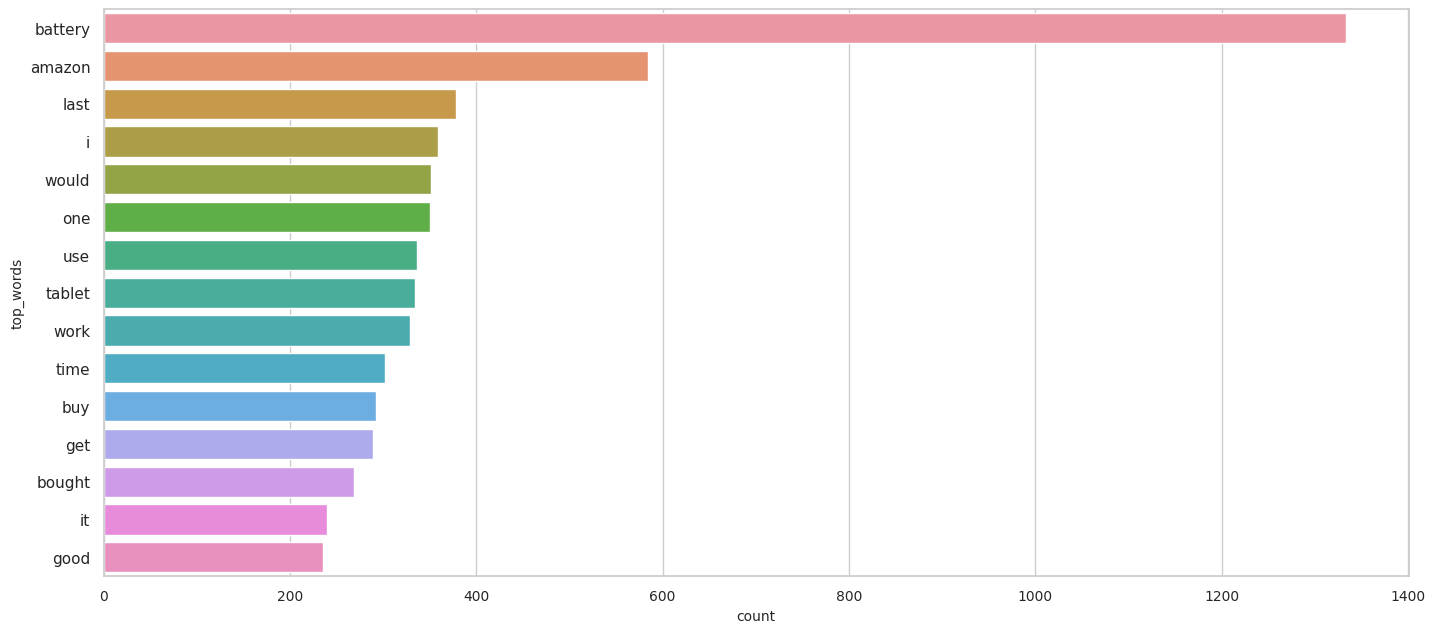

In [ ]:
# viewing the plot of top words of the negative sentiment class
df_negative_reviews = df_reviews[df_reviews['sentiment']=='Negative']
get_top_words_per_sentiment(df_negative_reviews)

The word battery is mentioned the most. This means that the customers have a lot of negative reviews regarding the battery of the products they bought on Amazon.

Additionally, words such as tablet and good are also showing up here, which is again similar to the ones that were seen in positive and neutral class top words. Looking at the negative reviews [here](#scrollTo=WmENclZifpgI) reveal that they have positive word without negation such as "...good for others" or they have positive word with negation such as "not good...". If these common words appear in a review, then the model can have confusion while classifying the review as positive, negative, or neutral. Hence, I am speculating that a few of the negative reviews might get classified as positive sentiment or neutral sentiment and vice versa.

## Data Splitting

Splitting data using `stratified sampling` to force the `same class balance` in the train, validate, and test dataset as in the original dataset.

In [ ]:
# creating 20% of original dataset as the test dataset while keeping the remaining dataset
remaining, test = train_test_split(df_reviews, test_size = 0.2, stratify=df_reviews['sentiment_score'])

In [ ]:
# preparing the test dataset
X_remaining = remaining['text']
X_test = test['text']
y_remaining = remaining['sentiment_score']
y_test = test['sentiment_score']

In [ ]:
# viewing the shape of the datasets
print(X_remaining.shape, X_test.shape, y_remaining.shape, y_test.shape)

(28980,) (7246,) (28980,) (7246,)


In [ ]:
# creating 20% of remaining dataset as the validation dataset while keeping the train dataset
train, validate = train_test_split(remaining, test_size = 0.2, stratify=remaining['sentiment_score'])

In [ ]:
# preparing the train dataset and validation dataset
X_train = train['text']
X_validate = validate['text']
y_train = train['sentiment_score']
y_validate = validate['sentiment_score']

In [ ]:
# viewing the shape of the datasets
print(X_train.shape, X_validate.shape, y_train.shape, y_validate.shape)

(23184,) (5796,) (23184,) (5796,)


## Tokenization

All the `words` in the train set will have to `tokenized`. For tokenization, a class named SentimentTokenizer will be created that basically indexes all the words in the text and each word gets a unique index. It will create a `dictionary of unique words as keys and index as value`. This dictionary will help in preparing the embedding layer later on.

In [ ]:
# defininig a sentiment tokenizer class
class SentimentTokenizer:

  # initializes the tokenizer using the vocabulary size and the out of vocabulary (oov) token
  def __init__(self, vocabulary_size=1000,oov_token = "<OOV>"):
    self.vocabulary_size = vocabulary_size
    self.oov_token = oov_token
    self.tokenizer = Tokenizer(num_words=self.vocabulary_size, oov_token=self.oov_token)

  # fits the tokenizer on the training data
  def fit(self, train_data):
    self.tokenizer.fit_on_texts(train_data)

  # gets the dictionary of words-index pairs
  def get_word_index(self):
    word_index = self.tokenizer.word_index
    return word_index

  # gets the vocabulary size
  def get_vocabulary_size(self):
    vocabulary_size = len(self.get_word_index())
    return vocabulary_size

  # representing the text as a sequence of numbers
  def convert(self, data):
    sequenced_data = self.tokenizer.texts_to_sequences(data)
    return sequenced_data

In [ ]:
# creating a tokenizer and fitting it to the train text
current_tokenizer = SentimentTokenizer()
current_tokenizer.fit(X_train)
word_index = current_tokenizer.get_word_index()
vocabulary_size = current_tokenizer.get_vocabulary_size()

# representing the train, validate, and test text as a sequence of numbers
X_train_sequences = current_tokenizer.convert(X_train)
X_validate_sequences = current_tokenizer.convert(X_validate)
X_test_sequences = current_tokenizer.convert(X_test)

## Padding

The sequences created through tokenization are of varying lengths. Usually, a sequnce of same length is passed to the ML model. All the `sequences` have to be `padded` in order to make usre that all the sequences have the same length. `Longer sequences` will be `truncated` while `shorter ones` will be `padded with zeros`.

In [ ]:
# defininig a sentiment padder class
class SentimentPadder:

  # initializing the parameters
  def __init__(self, maximum_length=100, padding_type = 'post', truncation_type='post'):
    self.maximum_length = maximum_length
    self.padding_type = padding_type
    self.truncation_type = truncation_type

  # padding operations will take place at the end of the sequences
  def pad(self, data):
    padded_sequence = pad_sequences(data,maxlen=self.maximum_length,
                               padding=self.padding_type, truncating=self.truncation_type)
    return padded_sequence

In [ ]:
# creating a padder
current_padder = SentimentPadder()

# padding the train, validate, and test tokenized sequences
X_train_padded = current_padder.pad(X_train_sequences)
X_validate_padded = current_padder.pad(X_validate_sequences)
X_test_padded = current_padder.pad(X_test_sequences)

In [ ]:
# viewing if all the sequences are of same length in train data
X_train_padded

array([[ 20, 209,  28, ...,   0,   0,   0],
       [199, 222,  18, ...,   0,   0,   0],
       [ 25, 252,  40, ...,   0,   0,   0],
       ...,
       [ 12,  42,  76, ...,   0,   0,   0],
       [ 40, 276, 373, ...,   0,   0,   0],
       [ 13, 412,  26, ...,   0,   0,   0]], dtype=int32)

## Embedding

The `meaning of the word` is `encoded` in the form of a `real-valued vector`. As a result, in the same vector space, `words with similar meanings` will be `closer` and the `words with different meanings` will `repel`. So the words that are positive would be clustered close to each other and so will the negative ones. These are called word embeddings and is used for the `representation of words`.

In [ ]:
# extracting into a temporary folder
with zipfile.ZipFile('/tmp/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/glove')

In [ ]:
# obtaining the GloVe word embedding and append them to a dictionary 
embeddings_index = {}
glove_file = open('/tmp/glove/glove.6B.100d.txt')

for line in glove_file:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
glove_file.close()

print(f'Total number of word vectors = {len(embeddings_index)}')

Total number of word vectors = 400000


In [ ]:
# defininig a sentiment embedding class
class SentimentEmbedding:
  
  # initializing the parameters
  def __init__(self, maximum_length=100):
    self.maximum_length = maximum_length

  # gets the word embedding matrix for all the words in the word index
  def get_matrix(self, word_index):
    embedding_matrix = np.zeros((len(word_index) + 1, self.maximum_length))
    for word, index in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
            
    return embedding_matrix

  # gets the embedding layer
  def get_layer(self, vocabulary_size, embedding_matrix, trainable=False):
    embedding_layer = Embedding(input_dim=vocabulary_size + 1,
                            output_dim=self.maximum_length, weights=[embedding_matrix],
                            input_length=self.maximum_length, trainable=trainable)
    
    return embedding_layer

In [ ]:
# creating an embedder
current_embedding = SentimentEmbedding()

# creating an embedding layer that will serve as the first layer in the sentiment model
embedding_matrix = current_embedding.get_matrix(word_index)
embedding_layer = current_embedding.get_layer(vocabulary_size,embedding_matrix)

## Evaluation Metric

Even before the model is built, it is important to think about the `metric` which would be used to `evaluate the model`.

#### Accuracy

`Accuracy`: It is a widely used metric. However, for sentiment analysis with an imbalanced dataset, accuracy will not be an appropriate metric because if the model just learns to always classify the review as the majority class (here, positive), then it will be a highly accurate model. Say there are 95 positive reviews, 2 negative reviews, and 3 neutral reviews. Then if the model always classifies a review as positive, then the model is accurate 95% of the times. Even though this is a highly desirable accuracy, this model will not be a good one as it fails to correctly classify the minority classes.

Hence, accuracy `can not be relied on` and better performance metric is needed.





#### Better Metric

Following are the metrics that better suit the situation:

1. `Recall`: This is a very important metric specially if the review is negative. This is because if the model classifies the negative review as positive, then Amazon would not be able to improve its operations. For instance, if a Kindle device that was delivered to a customer did not match the color that was shown on Amazon's website, then the customer would post a negative review mentioning the same. Now, if the model classifies this review as a positive one, then Amazon will not know that it has to improve the image quality on their website to match the actual color of the Kindle device. This eventually means that the Product Listing on Amazon's website will end up not being improved. Hence, the model should have a `High Recall`.

2. `Precision`: This is an important metric as well but not as important as Recall. This is because if the model classifies a non negative review as a negative one, it wouldn't be an area of major concern. This issue can be handled by having a human in the loop who looks at all the negatively classified reviews for gauging the improvement areas for Amazon. For instance, assume that there was a positive review by a customer regarding the packaging of the Echo Dot and the model classifies it as a negative one. Now, the human in the loop can simply disregard this falsely classified negative review as it does not mentions anything that could lead Amazon to improve it's packaging process. Additionally, the `human in the loop` can feed these falsely classified reviews in a pipeline that does the post processing of such reviews and stores it in a training database. The data from this database can then be used to train the model and eventually improve its classification power. Hence, a higher precision is good, but even if its not that high, it is acceptable with the human in the loop.

3. `F1-Score`: This metric provides a `balance` between `Recall` and `Precision` and is the harmonic mean of them. It is an another important metric and a value close to 1 is desirable. However, it doesn't matter much here because for this imbalanced dataset, it is not as important as Recall.

Hence, `Recall` will be the `prime evaluation metric` for the `sentiment model`.

## Sentiment Model

### Whole Test Set


Terminology that will be frequently used in the upcoming paragraph:
1. `Results` correspond to the Recall, Precision, and F1 Score
2. `Minority Classes` correspond to the `Negative Class` and the `Neutral Class`

The `Whole Test Set` comprises of various tests that were conducted. This tests set lead to certain `decisions` with respect to `sentiment model building`:

- `Batch Sizes` such as `16`, `32`, `64`, `128`, `256`, `512`, and `1024` were tried. When the batch size was too small, the results for minority classes was low. This was probably because of the imbalance in data. Too small batch sizes might not have included examples from the minority classes to learn from. Hence, a larger batch size was used to ensure that each batch has a good chance of containing a few reviews from the minority classes. Finally, `better results` were obtained when the `batch Size` was `512`.
- `Different number of LSTM layers` were tried. When the LSTM layers were more than 2, the model was quickly overfitting as it had a lot of trianable parameters. Hence, tests were performed with `1` and `2` LSTM layers which gave better results than when the LSTM layers were greater than 2.
- `Different number of Units per LSTM layer` was tried. When Units per LSTM layer were `32` and `64`, the results were better compared to when the Units per LSTM layer were 128 or greater.
- `Different dropout values` were tried. When the dropout value was `0.1`, the network learned nothing but predicting every text to belong to the positive sentiment class. When the dropout was `0.2`, the network became better at recognizing the negative sentiment texts and a few of the neutral sentiment texts. Values for dropout such as `0.3` and `0.33` did not give good results. Hence, `0.2` was `finalized` for the `dropout value` in the LSTM layers.
- `Before the output layer`, a `single dense layer` and `no dense layer` was tried. When there was no dense layer before the output layer, the results were low. Whereas when there was a single dense layer, the results were better.
- `Different Epochs` were tried. `Better results` were obtained when the number of epochs were `200` rather than when they were `100` and `500`.
- For the `Patience` value during `Early Stopping`, a value `10% of the number of epochs` was chosen. Since the number of epochs was finalized to be 200, the patience value was set to `20`.
- During the `data cleaning stage`, both `Stemming` and `Lemmatization` were tried. The results obtained via Lemmatization were better than the ones using Stemming. Hence, lemmatization of words was carried out.

### Model Definition

In [ ]:
# defininig a sentiment model class
class SentimentModel:

  # initializing the parameters
  def __init__(self, embedding_layer, epochs = 200, batch_size = 512,
               verbose_level = 2, best_model_path = 'best_model.hdf5',
               patience = 20, class_weights=None):
    
    self.embedding_layer = embedding_layer
    self.epochs = epochs
    self.batch_size = batch_size
    self.verbose_level = verbose_level
    self.best_model_path = best_model_path
    self.patience = patience
    self.class_weights = class_weights

    self.callbacks = [
            EarlyStopping(monitor='val_loss', patience=self.patience, mode='min', min_delta=0.0001),
            ModelCheckpoint(best_model_path, monitor='val_loss', save_best_only=True, mode='min')
            ]

    # defining the model
    self.model = Sequential([
            self.embedding_layer,
            LSTM(64, dropout=0.2, return_sequences=True),
            LSTM(64, dropout=0.2),
            Dense(10, activation='relu'),
            Dense(number_of_classes, activation='softmax')
        ])
    
  # gets the summary of the model
  def get_summary(self):
    return self.model.summary()
    
  # compiles the model
  def compile(self, loss="sparse_categorical_crossentropy", optimizer= "adam", metrics=['accuracy']):
    self.model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

  # returns the history after the model is fit to the training data and validated using validation data
  def fit(self, X_train, y_train, X_validate, y_validate):
    history = self.model.fit(X_train, y_train, epochs=self.epochs,
                    validation_data=(X_validate,y_validate), callbacks=self.callbacks, shuffle=True,
                    verbose=self.verbose_level, batch_size=self.batch_size, class_weight=self.class_weights)
    
    return history

  # generates the accuracy graph showcasing training accuracy and validation accuracy
  def generate_accuracy_graph(self, history):
    plt.plot(history.history['accuracy'], 'b')
    plt.plot(history.history['val_accuracy'], 'r')
    plt.title('Model Accuracy'),
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    return plt.show()

  # generates the loss graph showcasing the training loss and validation loss
  def generate_loss_graph(self, history):
    plt.plot(history.history['loss'], 'b')
    plt.plot(history.history['val_loss'], 'r')
    plt.title('Model Loss'),
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    return plt.show()

  # gets the predicted sentiments for test texts using the best model
  def get_predicted_sentiments(self, X_test):
    best_model = load_model(self.best_model_path)
    y_pred = np.argmax(best_model.predict(X_test), axis=-1)
    return y_pred

  # plots the confusion matrix
  def plot_confusion_matrix(self, y_test, y_pred):
    ax = sns.heatmap(confusion_matrix(y_test,y_pred), annot=True,fmt='.2f')
    ax.set_xlabel('Predicted Sentiment')
    ax.set_ylabel('True Sentiment')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Negative','Neutral','Positve'])
    ax.yaxis.set_ticklabels(['Negative','Neutral','Positve'])
    return plt.show()

  # gets the classification report
  def get_classification_report(self, y_test, y_pred):
    return classification_report(y_test,y_pred)

### Different Sentiment Models

Since the data is highly imbalanced, following will be the sentiment models built:
1. `Initial Model`: The Initial Model will be `trained` on the `imbalanced data` and evaluated on the test data.
2. `Model with Class Weights`: The Model with Class Weights will be trained on the imbalanced data and evaluated on the test data. However, this model will be `trained` using `class weights` so that model `pays more attention` to the samples from `under-represented classes` i.e. negative class and neutral class. For this, class weights will be calculated and passed to the model while training.
3. `Model with Synthetic Oversampled Data`: The Model with Synthetic Oversampled Data will be trained on the balanced data and evaluated on the test data. Based on the original numeral sequences, `SMOTE` will be used to perform `data augmentation` by creating the `synthetic numeral sequences`. These synthetic are slightly different from the original numeral sequences.

### A Few Results

The image below shows the Recall, Precision, and F1 Score of the subset of the [whole test set](#Whole-Test-Set) for which decent results were obtained. These subset of results correspond to the four settings which are as follows:

1. `1 LSTM Layer with 32 Units`
2. `1 LSTM Layer with 64 Units`
3. `2 LSTM Layers with 32 Units`
4. `2 LSTM Layers with 64 Units`

A coloring scheme was used to differentiate the performance of different sentiment models per setting. The different sentiment models were evaluated based on Recall and following is the coloring relevance:

1. `Red`: In the current setting, red indicates that the model did not have a Recall as good as the other two and can be referred to as the model with `worst performance`.
2. `Yellow`: In the current setting, yellow indicates that the model had a Recall `better than` the model with the `worst performance`.
3. `Green`: In the current setting, green indicates that the model had a Recall `better than` the `other two` and can be referred to as the model with the `best performance`.

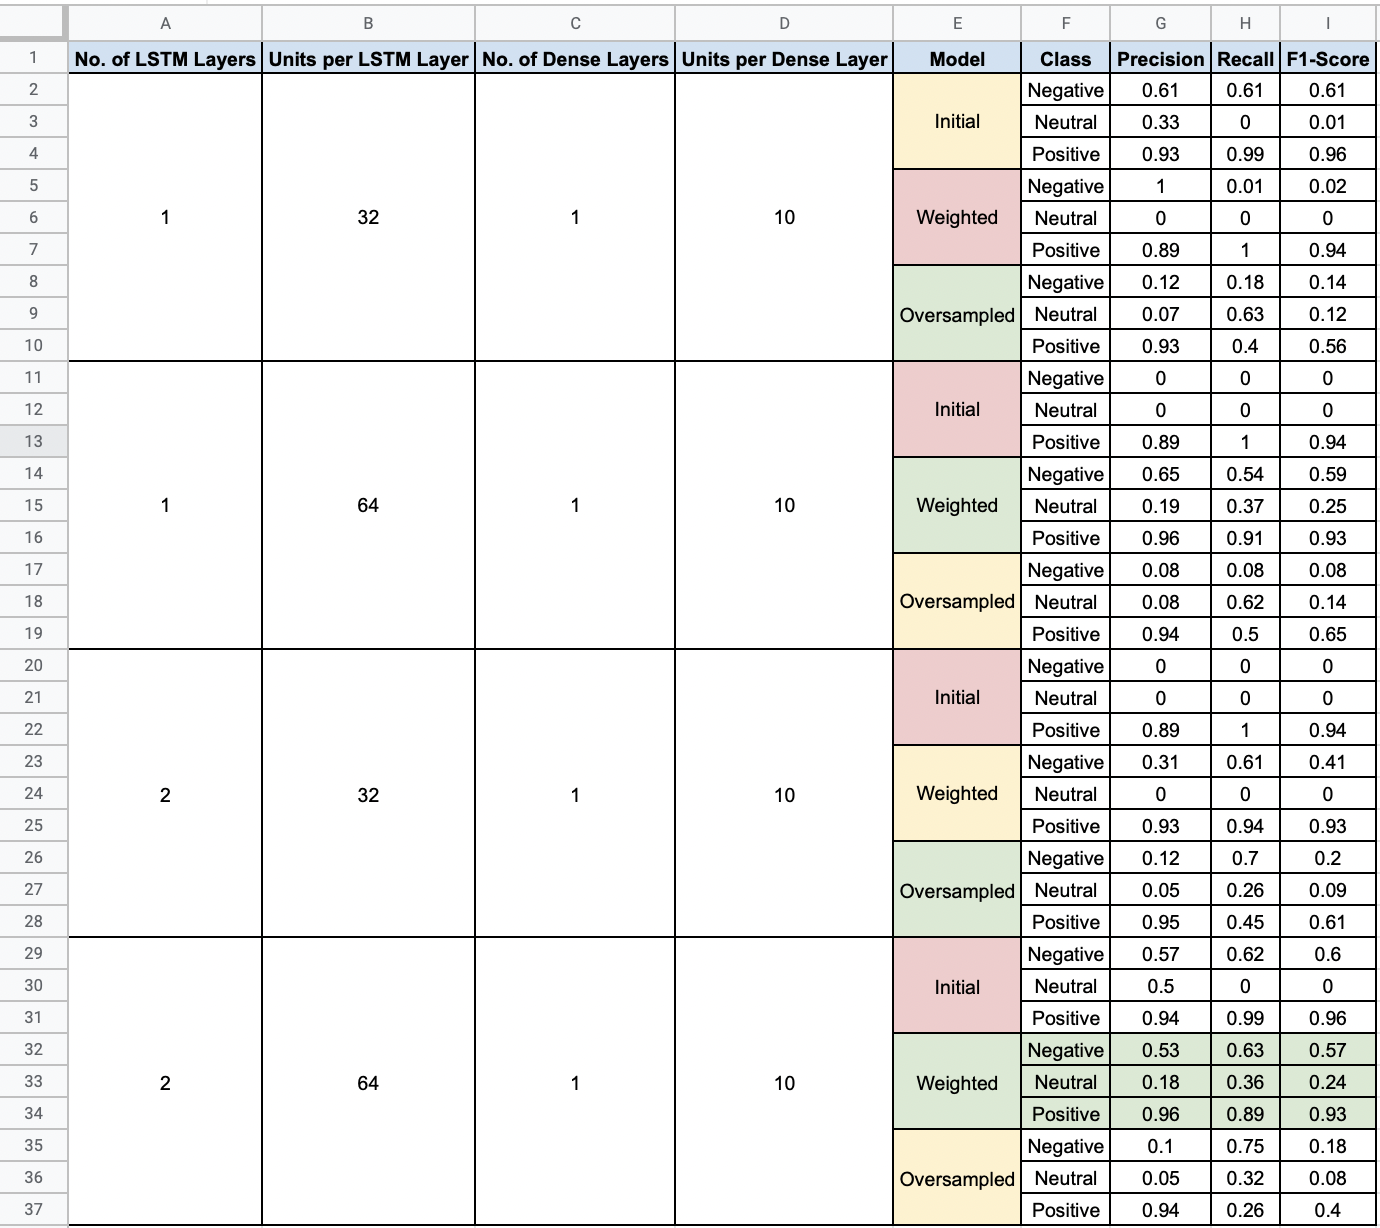

Based on the results seen above, the `Best Recalls` were obtained from the setting that had `2 LSTM Layers with 64 Units` (4th setting). This will be the setting that will be `covered in detail` in the `upcoming section`.

It can be seen that the Recall was higher with other setting as well say the 1 LSTM Layer with 64 Units setting (2nd setting). However, if the recall of negative class (0.54) of the weighted model from 2nd setting is compared with the recall of negative class (0.63) of the weighted model from 4th setting, then the 4th setting will be preferred. This is because Amazon would desire to capture as many negative reviews as possible to imporve its operations, given that the recall for the other two classes for both the setting is almost comparable.

## 2 LSTM Layers with 64 Units

Analyzing the different sentiment models under the setting with the best recalls.

### Initial Model

The Initial Model will be `trained` on the `imbalanced data` and evaluated on the test data.

In [ ]:
# building the initial model
initial_model = SentimentModel(embedding_layer=embedding_layer, best_model_path='best_initial_model.hdf5')
initial_model.get_summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1020100   
                                                                 
 lstm_6 (LSTM)               (None, 100, 64)           42240     
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 10)                650       
                                                                 
 dense_7 (Dense)             (None, 3)                 33        
                                                                 
Total params: 1,096,047
Trainable params: 75,947
Non-trainable params: 1,020,100
_________________________________________________________________


In [ ]:
# compiling the initial model
initial_model.compile()

In [ ]:
# fitting the initial model
initial_model_history = initial_model.fit(X_train_padded,y_train,X_validate_padded,y_validate)

Epoch 1/200
46/46 - 5s - loss: 0.5490 - accuracy: 0.8744 - val_loss: 0.4148 - val_accuracy: 0.8923 - 5s/epoch - 99ms/step
Epoch 2/200
46/46 - 1s - loss: 0.4146 - accuracy: 0.8923 - val_loss: 0.4142 - val_accuracy: 0.8866 - 976ms/epoch - 21ms/step
Epoch 3/200
46/46 - 1s - loss: 0.4095 - accuracy: 0.8918 - val_loss: 0.4187 - val_accuracy: 0.8920 - 939ms/epoch - 20ms/step
Epoch 4/200
46/46 - 1s - loss: 0.4178 - accuracy: 0.8920 - val_loss: 0.4167 - val_accuracy: 0.8920 - 883ms/epoch - 19ms/step
Epoch 5/200
46/46 - 1s - loss: 0.4165 - accuracy: 0.8920 - val_loss: 0.4160 - val_accuracy: 0.8920 - 878ms/epoch - 19ms/step
Epoch 6/200
46/46 - 1s - loss: 0.4168 - accuracy: 0.8920 - val_loss: 0.4159 - val_accuracy: 0.8920 - 884ms/epoch - 19ms/step
Epoch 7/200
46/46 - 1s - loss: 0.4163 - accuracy: 0.8920 - val_loss: 0.4159 - val_accuracy: 0.8920 - 880ms/epoch - 19ms/step
Epoch 8/200
46/46 - 1s - loss: 0.4163 - accuracy: 0.8920 - val_loss: 0.4158 - val_accuracy: 0.8920 - 888ms/epoch - 19ms/step
Epo

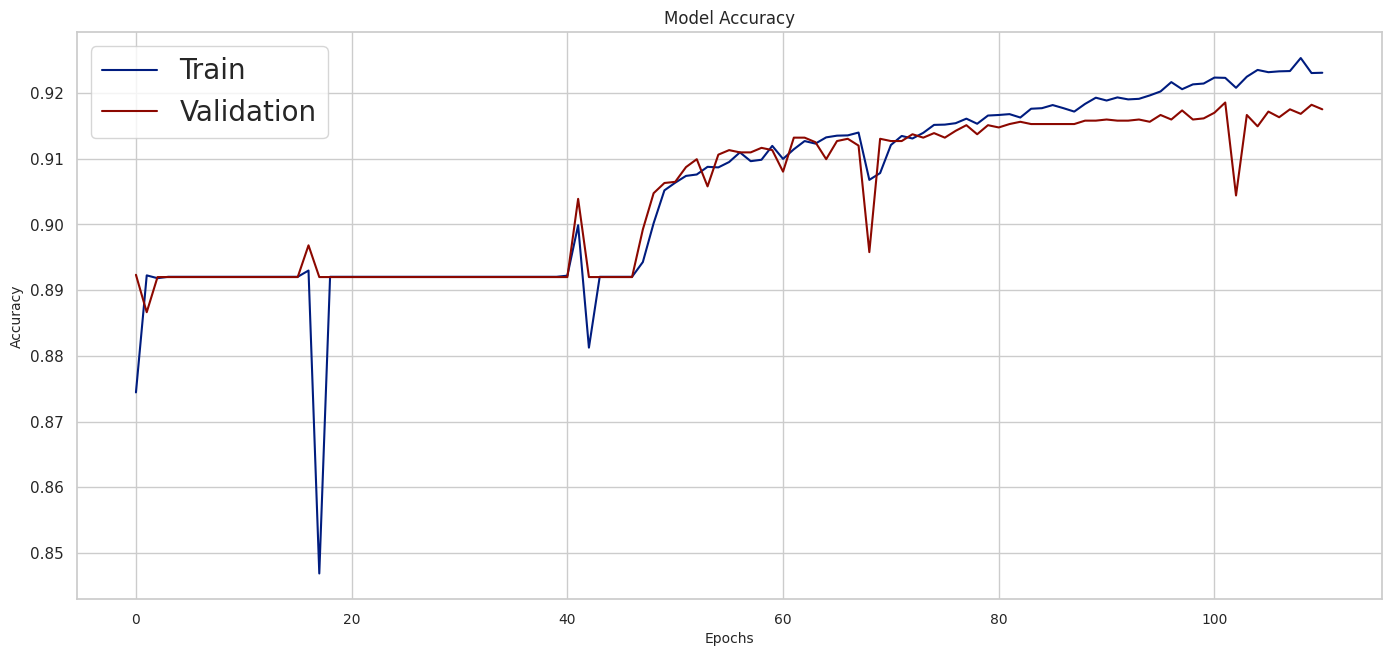

In [ ]:
# generating the graph of training accuracy and validation accuracy for the initial model
initial_model.generate_accuracy_graph(initial_model_history)

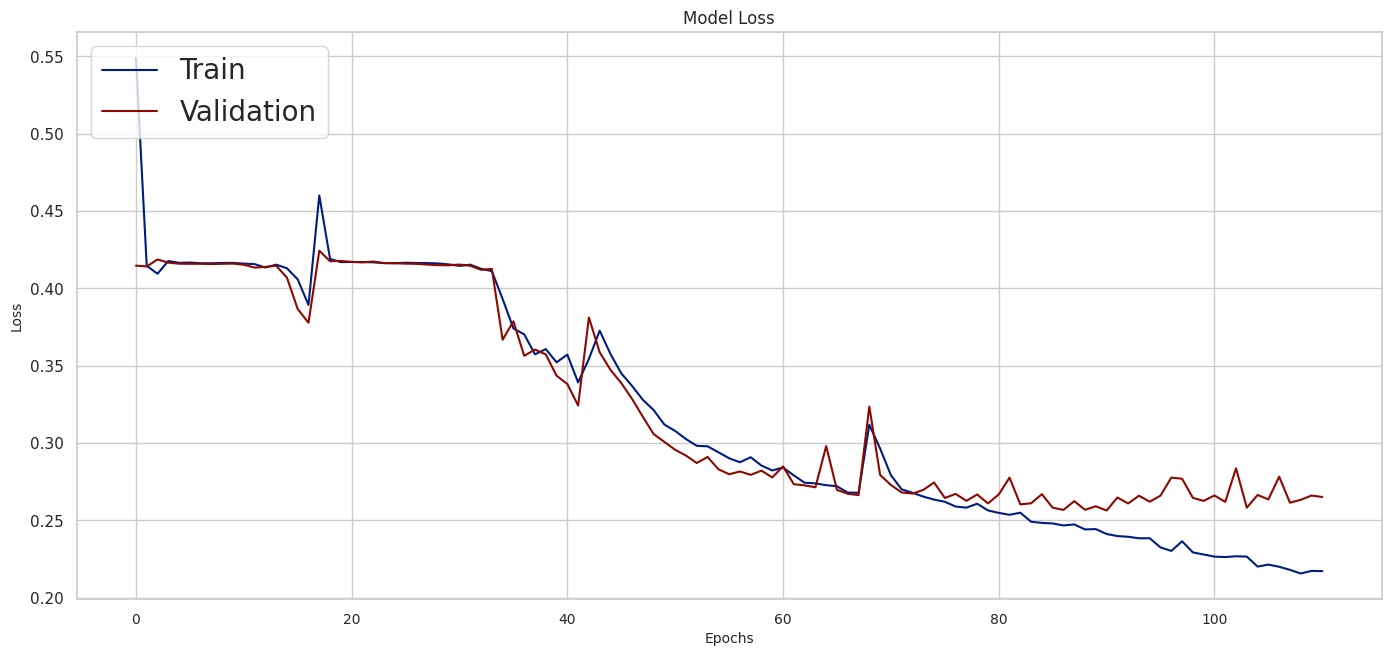

In [ ]:
# generating the graph of training loss and validation loss for the initial model
initial_model.generate_loss_graph(initial_model_history)

In [ ]:
# getting the predicted sentiments for the test set via the initial model
initial_y_pred = initial_model.get_predicted_sentiments(X_test_padded)

227/227 [==============================] - 2s 6ms/step


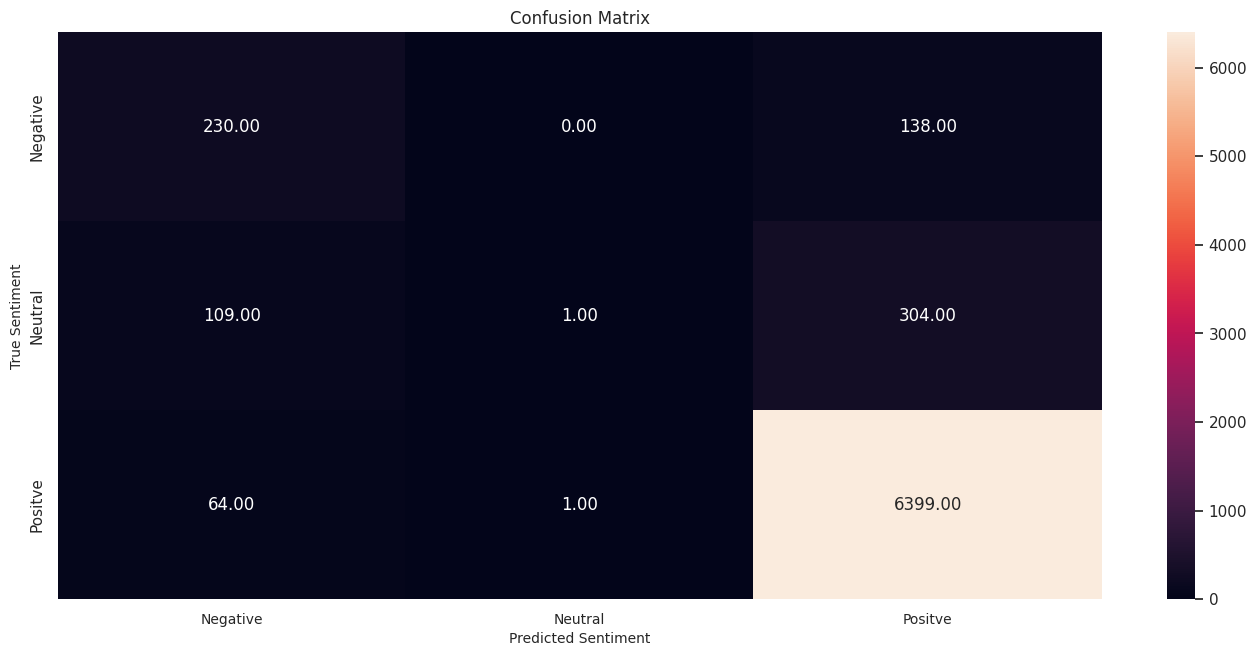

In [ ]:
# plotting the confusion matrix using the actual sentiment and predicted sentiment
initial_model.plot_confusion_matrix(y_test,initial_y_pred)

In [ ]:
# printing the classification report that shows the Precision, Recall, and F1-Score per sentiment class
print(initial_model.get_classification_report(y_test,initial_y_pred))

              precision    recall  f1-score   support

           0       0.57      0.62      0.60       368
           1       0.50      0.00      0.00       414
           2       0.94      0.99      0.96      6464

    accuracy                           0.91      7246
   macro avg       0.67      0.54      0.52      7246
weighted avg       0.89      0.91      0.89      7246



The initial model (red) has an almost `perfect recall` for `positive class` and `decently high recall` for the `negative class`. However, it has `0 recall` for the `neutral class`. Hence, this model is able to correctly classify the positive reviews almost perfectly, but performs poorly when it comes to classifying the review as neutral.

This model `generalizes extremely well` for the `positive reviews` and could be referred to as the best model if the aim was to classify the positive reviews with high recall.


### Model with Class Weights

The Model with Class Weights will be trained on the imbalanced data and evaluated on the test data.

However, this model will be `trained` using `class weights` so that model `pays more attention` to the samples from `under-represented classes` i.e. negative class and neutral class. For this, class weights will be calculated and passed to the model while training.

In [ ]:
# setting up the class weights dictionary that will be given as input to the weighted model while fitting
class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 6.549152542372881, 1: 5.841269841269841, 2: 0.3736763212610609}

In [ ]:
# building the weighted model
weighted_model = SentimentModel(embedding_layer=embedding_layer, best_model_path='best_weighted_model.hdf5', class_weights=class_weights)
weighted_model.get_summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1020100   
                                                                 
 lstm_2 (LSTM)               (None, 100, 64)           42240     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
 dense_3 (Dense)             (None, 3)                 33        
                                                                 
Total params: 1,096,047
Trainable params: 75,947
Non-trainable params: 1,020,100
_________________________________________________________________


In [ ]:
# compiling the weighted model
weighted_model.compile()

In [ ]:
# fitting the weighted model
weighted_model_history = weighted_model.fit(X_train_padded,y_train,X_validate_padded,y_validate)

Epoch 1/200
46/46 - 5s - loss: 1.0977 - accuracy: 0.3305 - val_loss: 1.1632 - val_accuracy: 0.0509 - 5s/epoch - 105ms/step
Epoch 2/200
46/46 - 1s - loss: 1.0111 - accuracy: 0.7201 - val_loss: 0.9846 - val_accuracy: 0.1568 - 978ms/epoch - 21ms/step
Epoch 3/200
46/46 - 1s - loss: 0.9407 - accuracy: 0.7722 - val_loss: 0.6684 - val_accuracy: 0.8521 - 926ms/epoch - 20ms/step
Epoch 4/200
46/46 - 1s - loss: 0.8791 - accuracy: 0.7169 - val_loss: 0.4507 - val_accuracy: 0.8520 - 927ms/epoch - 20ms/step
Epoch 5/200
46/46 - 1s - loss: 0.8764 - accuracy: 0.7135 - val_loss: 0.6096 - val_accuracy: 0.8247 - 896ms/epoch - 19ms/step
Epoch 6/200
46/46 - 1s - loss: 0.8604 - accuracy: 0.6711 - val_loss: 0.8266 - val_accuracy: 0.6403 - 898ms/epoch - 20ms/step
Epoch 7/200
46/46 - 1s - loss: 0.8376 - accuracy: 0.6809 - val_loss: 0.6452 - val_accuracy: 0.7553 - 944ms/epoch - 21ms/step
Epoch 8/200
46/46 - 1s - loss: 0.8251 - accuracy: 0.6762 - val_loss: 0.6934 - val_accuracy: 0.7300 - 897ms/epoch - 20ms/step
Ep

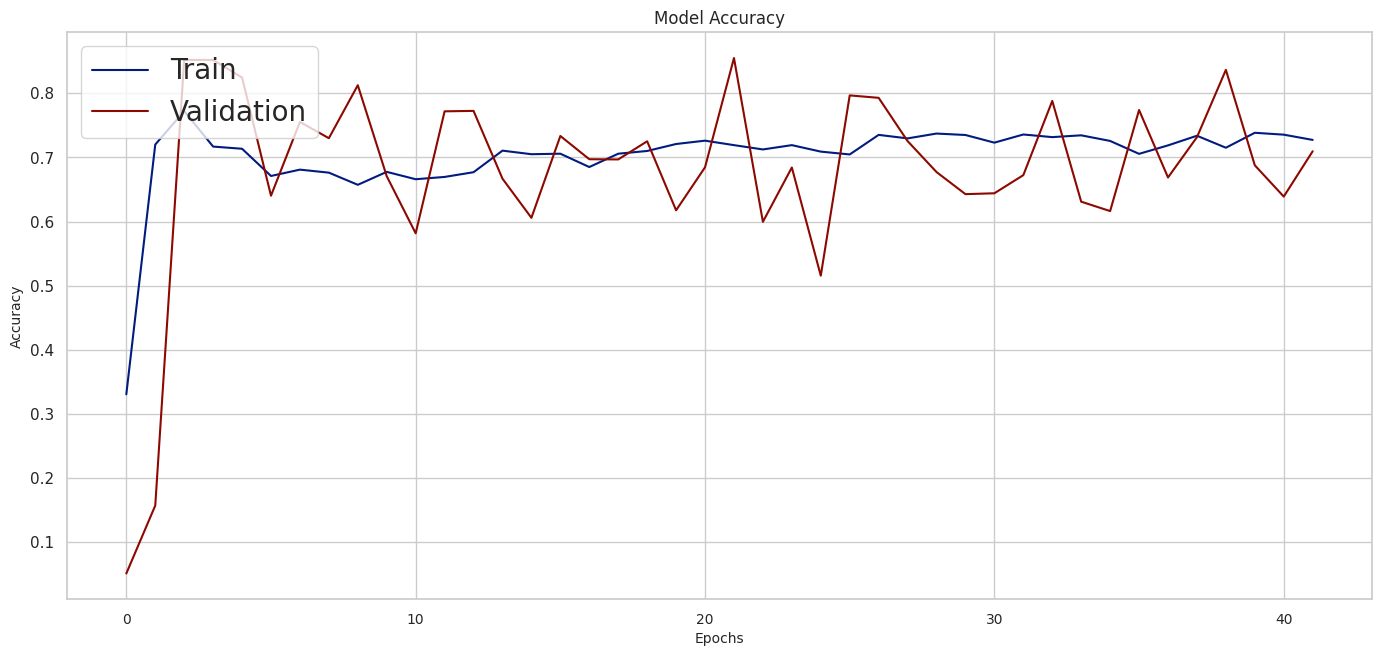

In [ ]:
# generating the graph of training accuracy and validation accuracy for the weighted model
weighted_model.generate_accuracy_graph(weighted_model_history)

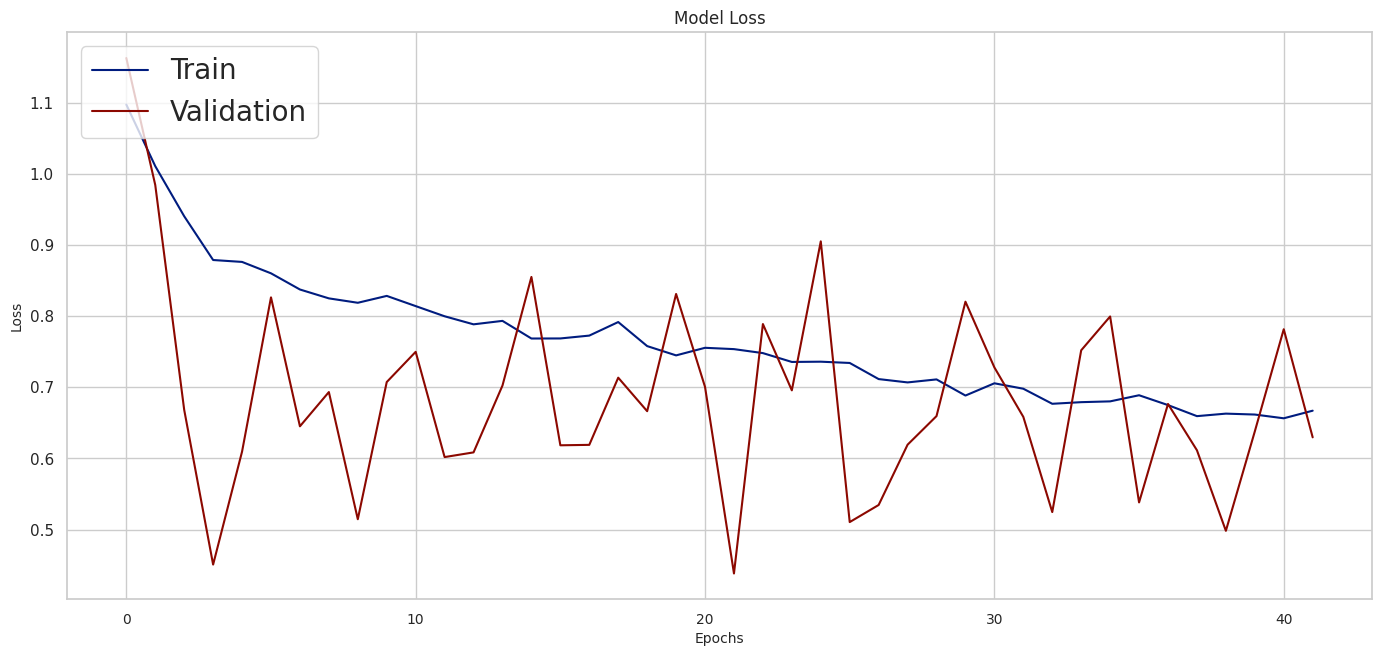

In [ ]:
# generating the graph of training loss and validation loss for the weighted model
weighted_model.generate_loss_graph(weighted_model_history)

In [ ]:
# getting the predicted sentiments for the test set via the weighted model
weighted_y_pred = weighted_model.get_predicted_sentiments(X_test_padded)

227/227 [==============================] - 2s 5ms/step


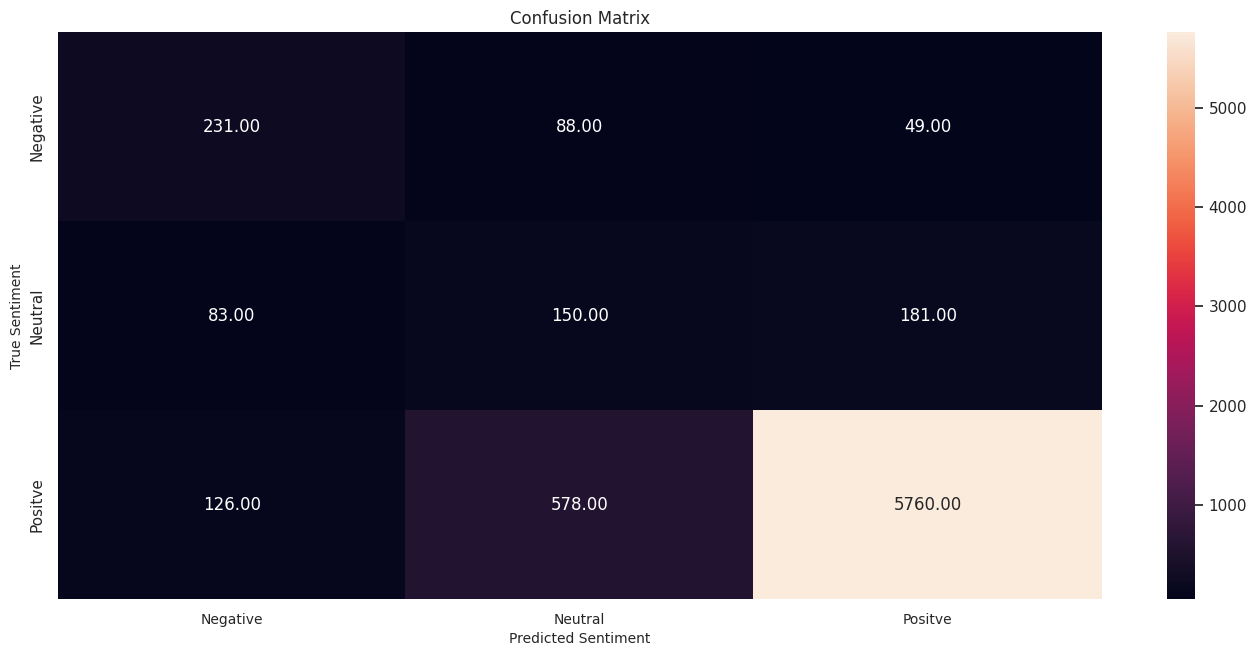

In [ ]:
# plotting the confusion matrix using the actual sentiment and predicted sentiment
weighted_model.plot_confusion_matrix(y_test,weighted_y_pred)

In [ ]:
# printing the classification report that shows the Precision, Recall, and F1-Score per sentiment class
print(weighted_model.get_classification_report(y_test,weighted_y_pred))

              precision    recall  f1-score   support

           0       0.53      0.63      0.57       368
           1       0.18      0.36      0.24       414
           2       0.96      0.89      0.93      6464

    accuracy                           0.85      7246
   macro avg       0.56      0.63      0.58      7246
weighted avg       0.89      0.85      0.87      7246



The weighted model (green) has a `very high recall` for the `positive class` and `decently high recall` for the `negative class`. As compared to the initial model, this model is able to classify the `neutral reviews` with a `higher recall`. Using class weights helped model pay more attention to the reviews from the under represented neutral and negative classes. It is `better` at `differentiating the neutral reviews from the positive and the negative` ones. Hence, this model is `better` at `classifying reviews` of `all three classes` than the initial model.


### Model with Synthetic Oversampled Data

The Model with Synthetic Oversampled Data will be trained on the balanced data and evaluated on the test data.

Based on the original numeral sequences, `SMOTE` will be used to perform `data augmentation` by creating the `synthetic numeral sequences`. These synthetic are slightly different from the original numeral sequences.

In [ ]:
# creating a new tokenizer by fitting to the remaining data (data that was remaining after the test data split done before)
oversampled_tokenizer = SentimentTokenizer()
oversampled_tokenizer.fit(X_remaining)
oversampled_word_index = oversampled_tokenizer.get_word_index()
oversampled_vocabulary_size = oversampled_tokenizer.get_vocabulary_size()

X_remaining_sequences = oversampled_tokenizer.convert(X_remaining)

In [ ]:
# padding the remaining data
oversampled_padder = SentimentPadder()
X_remaining_padded = oversampled_padder.pad(X_remaining_sequences)

In [ ]:
# oversampling the remaining data using SMOTE
X_train_oversampled, y_train_oversampled = SMOTE().fit_resample(X_remaining_padded,y_remaining)

In [ ]:
# creating a dataframe and splitting the remaining dataset between training dataset and validation dataset stratified on the sentiment score to have equal distribution
X_train_oversampled = pd.Series(X_train_oversampled.tolist())
df_oversampled = pd.DataFrame({'text':X_train_oversampled, 'sentiment_score':y_train_oversampled})
oversampled_train, oversampled_validate = train_test_split(df_oversampled,test_size = 0.2, stratify=df_oversampled['sentiment_score'])

In [ ]:
# creating oversampled training dataset and validation dataset
X_oversampled_train = oversampled_train['text']
X_oversampled_validate = oversampled_validate['text']
y_oversampled_train = oversampled_train['sentiment_score']
y_oversampled_validate = oversampled_validate['sentiment_score']

print(X_oversampled_train.shape, X_oversampled_validate.shape, y_oversampled_train.shape, y_oversampled_validate.shape)

(62042,) (15511,) (62042,) (15511,)


In [ ]:
# padding the training text and validation text
X_oversampled_train_padded = oversampled_padder.pad(X_oversampled_train)
X_oversampled_validate_padded = oversampled_padder.pad(X_oversampled_validate)

In [ ]:
# creating a new embedding layer that is based on the remaining data
oversampled_embedding = SentimentEmbedding()
oversampled_embedding_matrix = oversampled_embedding.get_matrix(oversampled_word_index)
oversampled_embedding_layer = oversampled_embedding.get_layer(oversampled_vocabulary_size,oversampled_embedding_matrix)

In [ ]:
# building the oversampled model
oversampled_model = SentimentModel(embedding_layer=oversampled_embedding_layer, best_model_path='best_oversampled_model.hdf5')
oversampled_model.get_summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1127600   
                                                                 
 lstm_4 (LSTM)               (None, 100, 64)           42240     
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 10)                650       
                                                                 
 dense_5 (Dense)             (None, 3)                 33        
                                                                 
Total params: 1,203,547
Trainable params: 75,947
Non-trainable params: 1,127,600
_________________________________________________________________


In [ ]:
# compiling the oversampled model
oversampled_model.compile()

In [ ]:
# fitting the oversampled model
oversampled_model_history = oversampled_model.fit(X_oversampled_train_padded,y_oversampled_train,X_oversampled_validate_padded,y_oversampled_validate)

Epoch 1/200
122/122 - 12s - loss: 1.0862 - accuracy: 0.3810 - val_loss: 1.0711 - val_accuracy: 0.4168 - 12s/epoch - 102ms/step
Epoch 2/200
122/122 - 2s - loss: 0.9928 - accuracy: 0.4785 - val_loss: 0.9199 - val_accuracy: 0.5201 - 2s/epoch - 20ms/step
Epoch 3/200
122/122 - 2s - loss: 0.8826 - accuracy: 0.5383 - val_loss: 0.8181 - val_accuracy: 0.5653 - 2s/epoch - 19ms/step
Epoch 4/200
122/122 - 2s - loss: 0.8245 - accuracy: 0.5621 - val_loss: 0.7733 - val_accuracy: 0.5822 - 2s/epoch - 20ms/step
Epoch 5/200
122/122 - 2s - loss: 0.7827 - accuracy: 0.5818 - val_loss: 0.7418 - val_accuracy: 0.5989 - 2s/epoch - 20ms/step
Epoch 6/200
122/122 - 2s - loss: 0.7602 - accuracy: 0.5903 - val_loss: 0.7190 - val_accuracy: 0.6089 - 2s/epoch - 20ms/step
Epoch 7/200
122/122 - 2s - loss: 0.7429 - accuracy: 0.5994 - val_loss: 0.7427 - val_accuracy: 0.5944 - 2s/epoch - 19ms/step
Epoch 8/200
122/122 - 2s - loss: 0.7351 - accuracy: 0.6013 - val_loss: 0.7007 - val_accuracy: 0.6118 - 2s/epoch - 20ms/step
Epoch

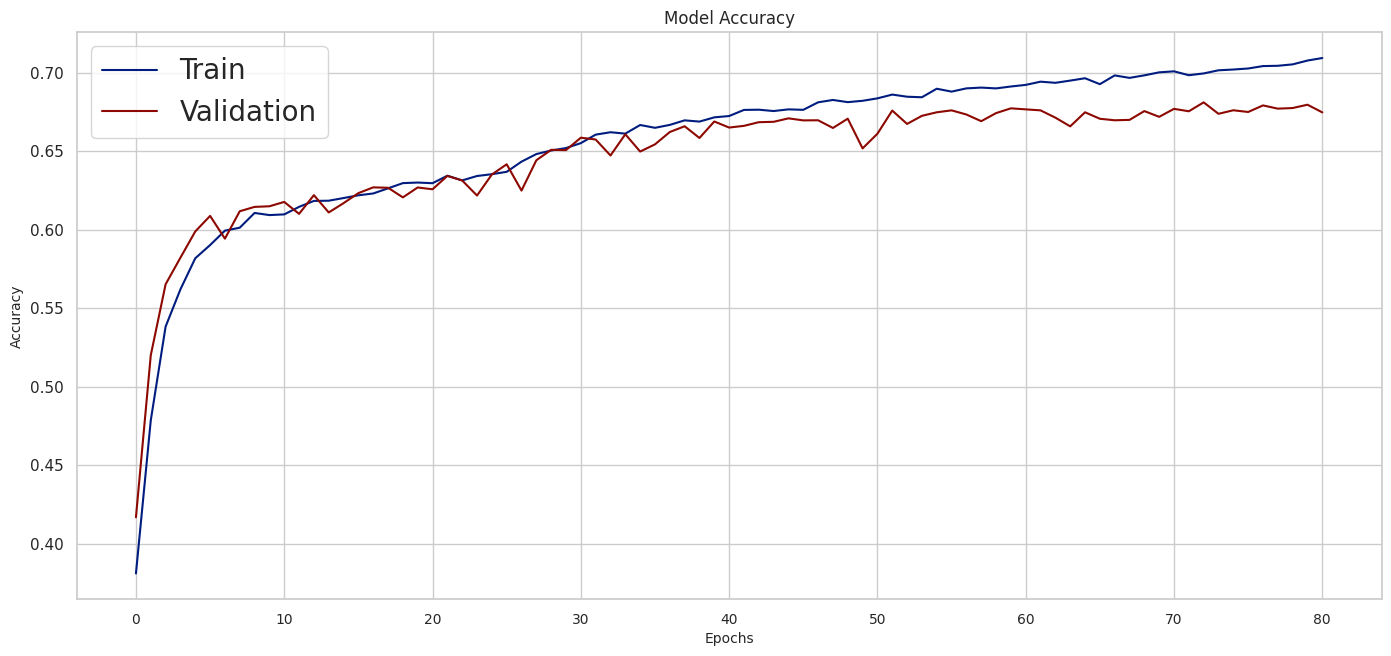

In [ ]:
# generating the graph of training accuracy and validation accuracy for the oversampled model
oversampled_model.generate_accuracy_graph(oversampled_model_history)

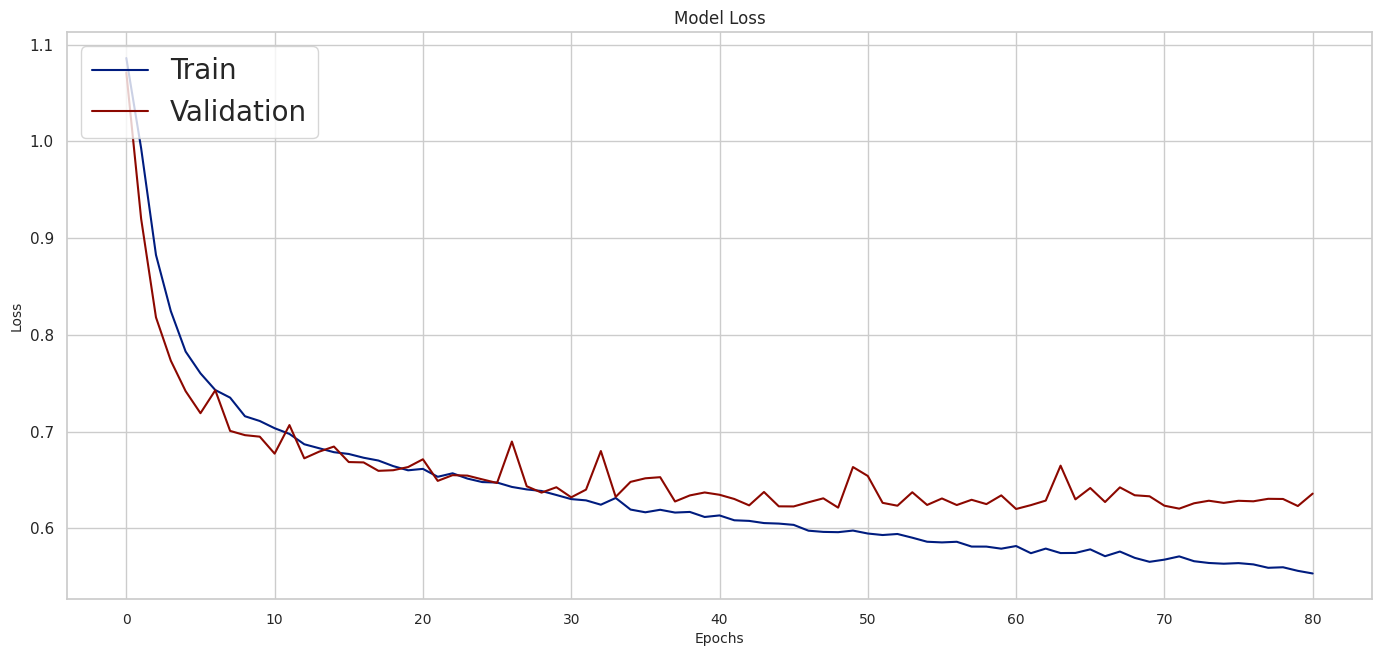

In [ ]:
# generating the graph of training loss and validation loss for the oversampled model
oversampled_model.generate_loss_graph(oversampled_model_history)

In [ ]:
# getting the predicted sentiments for the test set via the oversampled model
oversampled_y_pred = oversampled_model.get_predicted_sentiments(X_test_padded)

227/227 [==============================] - 2s 6ms/step


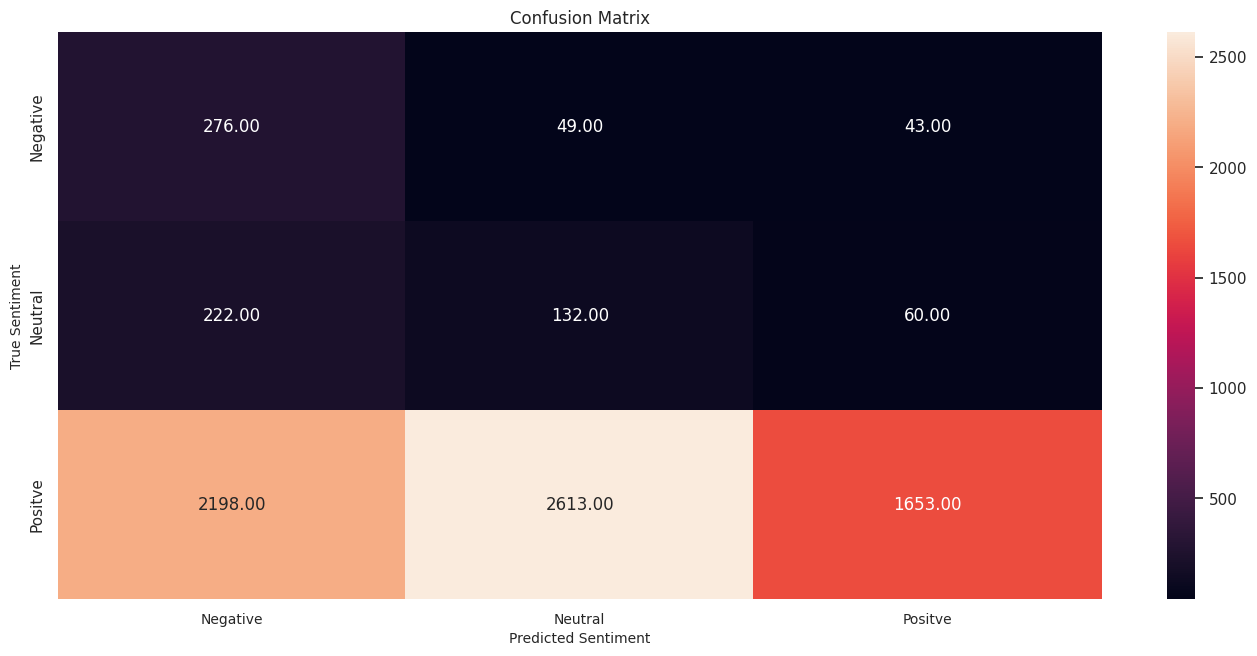

In [ ]:
# plotting the confusion matrix using the actual sentiment and predicted sentiment
oversampled_model.plot_confusion_matrix(y_test,oversampled_y_pred)

In [ ]:
# printing the classification report that shows the Precision, Recall, and F1-Score per sentiment class
print(oversampled_model.get_classification_report(y_test,oversampled_y_pred))

              precision    recall  f1-score   support

           0       0.10      0.75      0.18       368
           1       0.05      0.32      0.08       414
           2       0.94      0.26      0.40      6464

    accuracy                           0.28      7246
   macro avg       0.36      0.44      0.22      7246
weighted avg       0.85      0.28      0.37      7246



The oversampled model (yellow) has an `extremely low recall` for the `positive class`. It's recall value for the neutral class is comparable to the recall value for the neutral class from the weighted model.

The `recall` for the `negative class` of this model is `very high` and better than the recall for the negative class from the weighted model. This model would have been the best amongst all if the aim was to classify the negative reviews with high recall. Oversampling with synthetic data greatly helped the model to classify the negative reviews correctly.

Also, `precision` and `f1 score` for the `weighted model` is `far better` than this model. This model also started `classifying` the `positive reviews` as `negative` and `neutral` to a `large extent`. Hence, the weighted model is better than the oversampled model.



## Takeaways

Following are the `takeaways`:
1. The `best setting` turns out to be the `2 LSTM Layers` with `64 Units` along with a `dense layer` with `10 units`, `200` as the `epochs`, `20` as the `patience` during `early stopping`, `0.2` as the `dropout`, `512` as `batch size`, and `lemmatized words`.

2. The `best model` turns out to be the `Model with Class Weights` from the 2 LSTM Layers with 64 Units setting, which has `decently high recalls` for `all three classes` when compared to all the other models. For this dataset, `assigning class weights` while training helped the model to differentiate between negative, neutral, and positive classes better than other models.

3. One possible reason for not achieving extremely high recalls for all classes is that the `models` were `unable to distinguish` between certain reviews if they are absolutely negative, neutral, or poisitve. As [speculated earlier](#scrollTo=Mqbpxap06wB_), these certain reviews are the ones for which the model is getting confused and is not able to classify correctly. For example, `negative reviews` that have `positive words without negation`. Also, the words like `bought`, `good`, `use`, `it`, `amazon`, `one`, and so forth appeared in reviews from all classes and that eventually `confused` the `models` more.

4. If the `aim` was to `classify` the `negative reviews with high recall`, then the `Weighted Model` from the 2 LSTM Layers with 64 Units setting would have been the `best model`. For this dataset, `synthetically oversampling` the `data` before training helped the model to classify the negative reviews more accurately than other models.

5. If the `aim` was to `classify` the `positive reviews with high recall`, then the `initial model` from the 2 LSTM Layers with 64 Units setting would have been the `best model`. The `imbalanced dataset` was `enough to train` the model to correctly identify the positive reviews. This can be attributed to the fact that the dataset had a large amount of the `real positive reviews` for the model to learn from.

[Back to Top](#Sentiment-Analysis-of-Product-Reviews-leveraging-LSTM-Network)